# LUAD survival analysis

#### Data sources:
- `rna_cancer_sample.tsv`: Human Protein Atlas (https://www.proteinatlas.org/download/rna_cancer_sample.tsv.zip)
- `clinical.tsv`: TCGA (https://portal.gdc.cancer.gov/projects/TCGA-LUAD; click Clinical download button)

Data were pre-normalized as part of the Human Protein Atlas project

#### Table of contents:
<ul>
    <li><a href="#import">Import dependencies</a></li>
    <li><a href="#functions">Functions</a></li>
    <li><a href="#read">Read gene expression data and format</a></li>
    <li><a href="#censor">Read clinical data and format/censor</a></li>
    <li><a href="#summary">Data summaries</a></li>
    <li><a href="#sms">SMS (ENSG00000102172)</a></li>
        <ul>
           <li>All stages</li>
           <li>Early stages</li>
           <li>Late stages</li>
        </ul>
    <li><a href="#glyctk">GLYCTK (ENSG00000168237)</a></li>
        <ul>
           <li>All stages</li>
           <li>Early stages</li>
           <li>Late stages</li>
        </ul>
    <li><a href="#all">Perform analysis on all genes</a></li>    
    <li><a href="#rank">Rank order survival p-values</a></li>   
        <ul>
           <li>SMS</li>
           <li>GLYCTK</li>
        </ul>
    <li><a href="#plots">Plots</a></li>
        <ul>
           <li>All stages</li>
           <li>Early stages</li>
           <li>Late stages</li>
        </ul>
    <li><a href="#session">Session Info</a></li>
</ul>

<a id="import"><h3>Import dependencies</h3></a>

In [1]:
suppressWarnings({
    library(survival)
    library(survminer)
    library(stringr)
    library(data.table)

    setwd("C:/Users/jorda/Desktop/projects/Metaboverse-manuscript/rna_cancer_data/tcga_classic/")
})

Loading required package: ggplot2

Loading required package: ggpubr



<a id="functions"><h3>Functions</h3></a>

In [2]:
# Clean and prepare clinical data 
censor_df <- function (df) {
    # Censor alive==0/dead==1
    # See "event" description at https://www.rdocumentation.org/packages/survival/versions/2.11-4/topics/Surv
    censor_data <- function(x) if (x == "Alive") {0} else {1}
    df$status <- mapply(censor_data, df$vital_status)
    df$status <- as.numeric(df$status)
    df$days_to_death <- as.numeric(df$days_to_death) ##################### <-------- NAs
    
    # Right censor for alive
    # https://cran.r-project.org/web/packages/finalfit/vignettes/survival.html
    df$days_to_death <- ifelse(
        is.na(df$days_to_death), 
        df$days_to_last_follow_up, 
        df$days_to_death)
    
    df$days_to_death <- ifelse(
        df$days_to_death == "'--", 
        df$days_to_last_follow_up, 
        df$days_to_death)
    
    return (df)
}

clean_df <- function(df) {
    # Get relevant data and perform some additional data clean-up
    df <- df[ , c("case_submitter_id", "ajcc_pathologic_stage", "status", "days_to_death", "days_to_last_follow_up")] 

    # remove duplicate entries
    df <- unique(df[,])

    # remove samples with no days to death after censoring
    df <- df[df$days_to_death != "'--", ]

    # Make sure output formatting is correct
    df$status <- as.numeric(as.character(df$status))
    df$days_to_death <- as.numeric(as.character(df$days_to_death))
    
    return (df)
}

parse_stages <- function(df) {
    
    # Add stage category labels
    df$stage <- df$ajcc_pathologic_stage
    df <- df[df$stage != "'--", ]
    df$stage[
        df$stage == "Stage I" | 
        df$stage == "Stage IA" | 
        df$stage == "Stage IB"] <- 1
    df$stage[
        df$stage == "Stage II" | 
        df$stage == "Stage IIA" | 
        df$stage == "Stage IIB"] <- 2
    df$stage[
        df$stage == "Stage III" | 
        df$stage == "Stage IIIA" | 
        df$stage == "Stage IIIB"] <- 3
    df$stage[
        df$stage == "Stage IV" | 
        df$stage == "Stage IVA" | 
        df$stage == "Stage IVB"] <- 4

    # Parse out early vs. late patients
    early <- df[
        df$ajcc_pathologic_stage == "Stage I" | 
        df$ajcc_pathologic_stage == "Stage IA" | 
        df$ajcc_pathologic_stage == "Stage IB", ]
    late <- df[
        df$ajcc_pathologic_stage != "Stage I" & 
        df$ajcc_pathologic_stage != "Stage IA" & 
        df$ajcc_pathologic_stage != "Stage IB", ]
    all <- df
    
    v = list(all, early, late)
    names(v) <- c("all", "early", "late")
    
    return (v)
}

In [3]:
plot_day_dist <- function(df, export=FALSE) {
    if (export != FALSE) {
        pdf(export)
    }
    
    # initialize plotting space 
    par(mfrow=c(1,2), pin=c(3,1))
    
    # plot days to death for dead patients distribution
    x1 <- df[df$status == 1, ]$days_to_death
    h1 <-hist(x1, breaks=20, col="red", xlab="Days to Death", main="Dead")
    xfit1<-seq(min(x1),max(x1),length=40)
    yfit1<-dnorm(xfit1,mean=mean(x1),sd=sd(x1))
    yfit1 <- yfit1*diff(h1$mids[1:2])*length(x1)
    lines(xfit1, yfit1, col="red", lwd=2)
    
    # plot days to follow-up for alive patients distribution
    x2 <- df[df$status == 0, ]$days_to_death
    h2 <- hist(x2, breaks=20, col="blue", xlab="Days to Follow-up", main="Alive")
    xfit2<-seq(min(x2),max(x2),length=40)
    yfit2<-dnorm(xfit2,mean=mean(x2),sd=sd(x2))
    yfit2 <- yfit2*diff(h2$mids[1:2])*length(x2)
    lines(xfit2, yfit2, col="blue", lwd=2)
    
    if (export != FALSE) {
        dev.off()
    }
}

plot_gene_summary <- function(df, gene, title=NULL, export=FALSE, color="blue") {
    if (export != FALSE) {
        pdf(export)
    }
    
    if (is.null(title)) {
        title = gene
    }
    
    print(paste(title, "gene expression summary"))
    print(summary(df[df$Gene == gene,]$TPM))

    x2 <- df[df$Gene == gene, ]$TPM
    h2 <- hist(x2, breaks=100, col="grey", xlab="TPM", main=title)
    xfit2<-seq(min(as.numeric(na.omit(x2))),max(as.numeric(na.omit(x2))),length=40)
    yfit2<-dnorm(xfit2,mean=mean(as.numeric(na.omit(x2))),sd=sd(as.numeric(na.omit(x2))))
    yfit2 <- yfit2*diff(h2$mids[1:2])*length(as.numeric(na.omit(x2)))
    lines(xfit2, yfit2, col="blue", lwd=2)
    
    if (export != FALSE) {
        dev.off()
    }
}

In [4]:
analyze_all_genes <- function(expression, clinical, gene_list) {
    
    median_pvals <-list()
    optimized_pvals <- list()
    counter <- 0

    for (gene in gene_list) {
      tryCatch({
        data_gene <- expression[expression$Gene == gene,]
        # Merged mixed data tables
        merged_data_gene <- merge(
          data_gene,
          clinical,
          by.x = "Sample",
          by.y = "case_submitter_id")

        this_median <- median(merged_data_gene$TPM)
        merged_data_gene$gene_status <- ifelse(merged_data_gene$TPM > this_median, "high", "low")
        km_trt_fit <- surv_fit(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)

        opt_cutoff <- surv_cutpoint(
            merged_data_gene, 
            time = "days_to_death", 
            event = "status", 
            variables = c("TPM"),
            minprop=0.2)
        opt_categories <- surv_categorize(opt_cutoff)
        opt_fit <- surv_fit(Surv(days_to_death, status) ~ TPM, data = opt_categories)

        median_pvals[gene] <- surv_pvalue(km_trt_fit)$pval
        optimized_pvals[gene] <- surv_pvalue(opt_fit)$pval
          
      }, error = function (condition) {
        counter <- counter + 1
      })
    }
    print(paste("Skipped", counter, "genes", sep=" "))
    
    v = list(median_pvals, optimized_pvals)
    names(v) <- c("median", "optimized")
    
    return (v)
}

In [5]:
plot_scatter <- function(expression, clinical, gene, title=NULL, export=FALSE) {
    if (export != FALSE) {
        pdf(export)
    }
    
    if (is.null(title)) {
        title = gene
    }
    
    print(title)
    data_gene <- expression[expression$Gene == gene,]
    merged_data_gene <- merge(
      data_gene,
      clinical,
      by.x = "Sample",
      by.y = "case_submitter_id")

    plot(merged_data_gene$TPM, merged_data_gene$days_to_death)
    
    if (export != FALSE) {
        dev.off()
    }
}

In [6]:
get_best_cutoff <- function(expression, clinical, gene, title=NULL, stage="All", minprop=0.2) {
    if (is.null(title)) {
        title = gene
    }
    print(paste(stage, ":::", title))
    
    # K-M Curve
    data_gene <- expression[expression$Gene == gene,]
    # Merged mixed data tables
    merged_data_gene <- merge(
      data_gene,
      clinical,
      by.x = "Sample",
      by.y = "case_submitter_id")
    
    # Optimized threshold
    opt_cutoff <- surv_cutpoint(
        data = merged_data_gene, 
        time = "days_to_death", 
        event = "status", 
        variables = c("TPM"),
        minprop=minprop)
    opt_categories <- surv_categorize(x = opt_cutoff)
    opt_fit <- surv_fit(formula = Surv(days_to_death, status) ~ TPM, data = opt_categories)
    
    # Get p-values
    val_opt <- surv_pvalue(opt_fit)$pval

    # Print stats
    print(paste("Optimized cutoff:", opt_cutoff$cutpoint$cutpoint))
    print(paste("Best fit p-value:", val_opt))
    print(paste("high:", sum(str_count(opt_categories$TPM, "high"))))
    print(paste("low:", sum(str_count(opt_categories$TPM, "low"))))

    # Cox Regression
    res.cox <- coxph(Surv(days_to_death, status) ~ TPM, data=opt_categories)
    print(summary(res.cox))
 
    best_value = list(opt_fit, opt_cutoff, opt_cutoff$cutpoint$cutpoint, opt_categories, val_opt)
    names(best_value) = list("model", "cutoff_obj", "cutoff", "categories", "p_val")
    return (best_value)
}

use_cutoff <- function(expression, clinical, gene, cutoff, title=NULL, stage="All") {
    if (is.null(title)) {
        title = gene
    }
    print(paste(stage, ":::", title))
    
    data_gene <- expression[expression$Gene == gene,]
    # Merged mixed data tables
    merged_data_gene <- merge(
      data_gene,
      clinical,
      by.x = "Sample",
      by.y = "case_submitter_id")

    merged_data_gene$gene_status <- ifelse(merged_data_gene$TPM > cutoff, "high", "low")
    opt_fit <- surv_fit(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)

    # Get p-values
    val_opt <- surv_pvalue(opt_fit)$pval

    # Print stats
    print(paste("Used cutoff:", cutoff))
    print(paste("Used p-value:", val_opt))
    print(paste("high:", sum(str_count(merged_data_gene$gene_status, "high"))))
    print(paste("low:", sum(str_count(merged_data_gene$gene_status, "low"))))
    
    res.cox <- coxph(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)
    print(summary(res.cox))
    
    best_value = list(opt_fit, val_opt)
    names(best_value) = list("model", "p_val")
    return (best_value)
}

<a id="read"><h3>Read gene expression data and format</h3></a>

In [7]:
fpkm_data <- read.csv(
    file = 'rna_cancer_sample.tsv', 
    sep="\t")

In [8]:
# Extract LUAD data
fpkm_data_c <- fpkm_data[fpkm_data$Cancer == 'LUAD',]

In [9]:
# Clean up Sample IDs
fpkm_data_c$Sample <- sapply(strsplit(fpkm_data_c$Sample, "-01A"), "[", 1)
# fpkm_data_c <- unique(fpkm_data_c$Gene)
fpkm_data_c$FPKM <- as.numeric(fpkm_data_c$FPKM)

dim(fpkm_data_c)

[1] 9729000       4

**Convert RPKM to TPM**    
Source: https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/    
Rationale: https://hbctraining.github.io/DGE_workshop_salmon/lessons/02_DGE_count_normalization.html

In [10]:
# Long to wide format
wide_data <- dcast(fpkm_data_c, Gene ~ Sample, value.var = "FPKM")
wide_data <- data.frame(wide_data[,-1], row.names = wide_data[,1])

Warning message in dcast(fpkm_data_c, Gene ~ Sample, value.var = "FPKM"):
"The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(fpkm_data_c). In the next version, this warning will become an error."
Aggregation function missing: defaulting to length



In [11]:
# Convert FPKM to TPM
fpkmToTpm <- function(fpkm) {
    exp(log(fpkm) - log(sum(fpkm)) + log(1e6))
}
tpm_data <- fpkmToTpm(wide_data)

In [12]:
# Wide to long format
tpm_data$Gene <- row.names(tpm_data)
long_data <- melt(tpm_data, id.vars = c("Gene"), measure.vars = colnames(tpm_data))
setnames(long_data, "variable", "Sample")
setnames(long_data, "value", "TPM")

Warning message in melt(tpm_data, id.vars = c("Gene"), measure.vars = colnames(tpm_data)):
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(tpm_data). In the next version, this warning will become an error."


In [13]:
tpm_data <- long_data

In [14]:
tpm_data$Sample <- gsub('\\.', '-', tpm_data$Sample)

In [15]:
tpm_data$TPM <- as.numeric(tpm_data$TPM)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


In [16]:
head(tpm_data)

,Gene,Sample,TPM
,<chr>,<chr>,<dbl>
1,ENSG00000000003,TCGA-05-4249,0.1027855
2,ENSG00000000005,TCGA-05-4249,0.1027855
3,ENSG00000000419,TCGA-05-4249,0.1027855
4,ENSG00000000457,TCGA-05-4249,0.1027855
5,ENSG00000000460,TCGA-05-4249,0.1027855
6,ENSG00000000938,TCGA-05-4249,0.1027855


<a id="censor"><h3>Read clinical data and format/censor</h3></a> 

In [17]:
clinical_data <- read.csv(
    file = "clinical.tsv", 
    sep="\t")

clinical_data <- censor_df(
    clinical_data)
dim(clinical_data)

clinical_data <- clean_df(
    clinical_data)
dim(clinical_data)

clinical_data <- parse_stages(
    clinical_data)

Warning message in censor_df(clinical_data):
"NAs introduced by coercion"


[1] 1044  155

[1] 513   5

<a id="summary"><h3>Data summaries</h3></a>

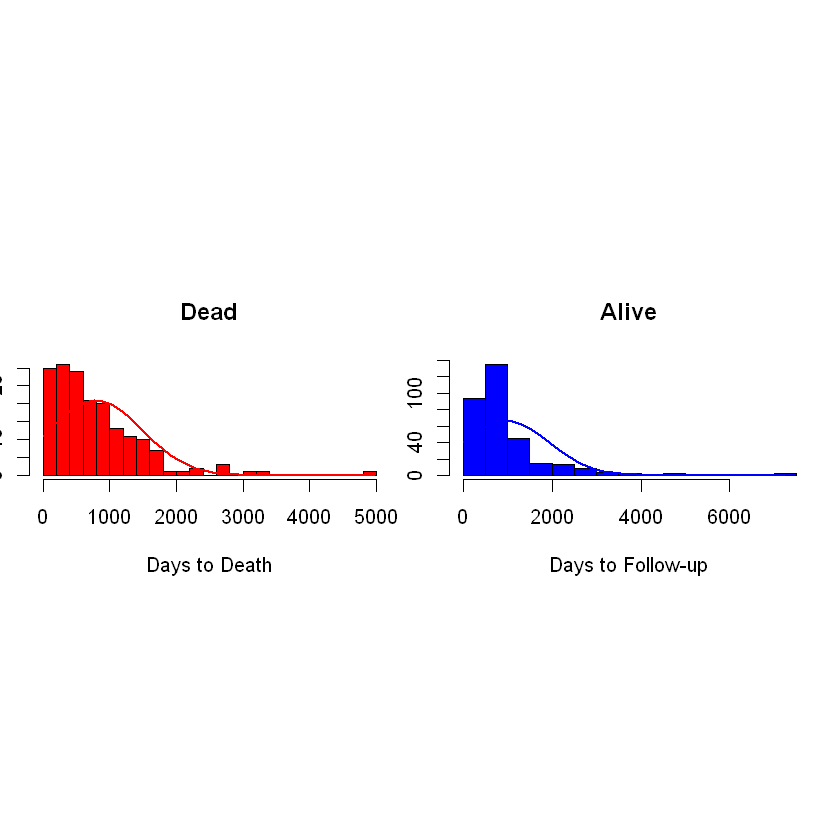

In [18]:
# plot day distribtions for groups
plot_day_dist(
    clinical_data$all)
    #export="patient_distribution.pdf")

In [19]:
plot_gene_summary(
    tpm_data, 
    "ENSG00000102172", 
    "SMS",
    export="gene_summary_sms.pdf")

[1] "SMS gene expression summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.1028  0.1028  0.1028  0.1028  0.1028  0.1028       1 


png 
  2

[1] "SMS gene expression summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.1028  0.1028  0.1028  0.1028  0.1028  0.1028       1 


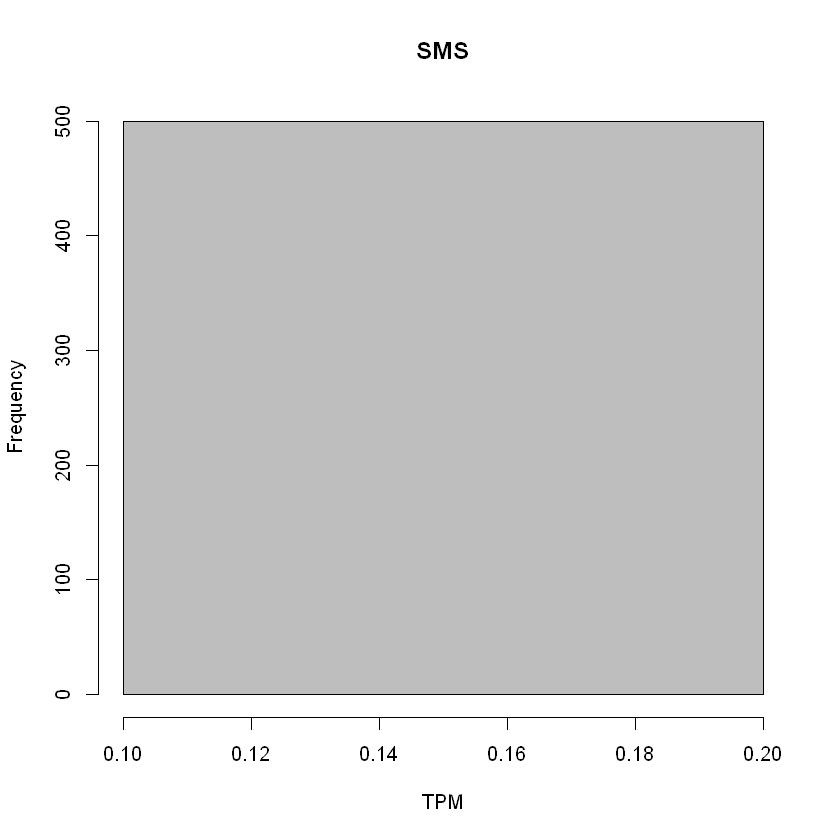

In [27]:
plot_gene_summary(
    tpm_data, 
    "ENSG00000102172", 
    "SMS")

In [21]:
plot_gene_summary(
    tpm_data, 
    "ENSG00000168237", 
    "GLYCTK",
    export="gene_summary_glyctk.pdf")

[1] "GLYCTK gene expression summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.1028  0.1028  0.1028  0.1028  0.1028  0.1028       1 


png 
  2

[1] "GLYCTK gene expression summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.1028  0.1028  0.1028  0.1028  0.1028  0.1028       1 


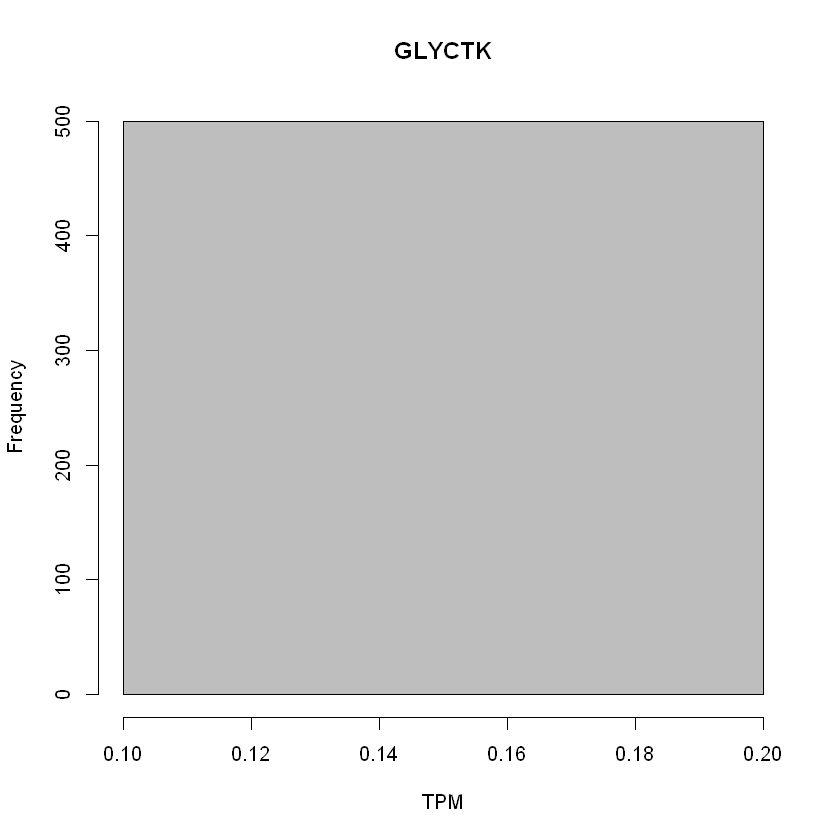

In [22]:
plot_gene_summary(
    tpm_data, 
    "ENSG00000168237", 
    "GLYCTK")
    #export="gene_summary_glyctk.pdf")

In [23]:
# Plot both in same plotting space

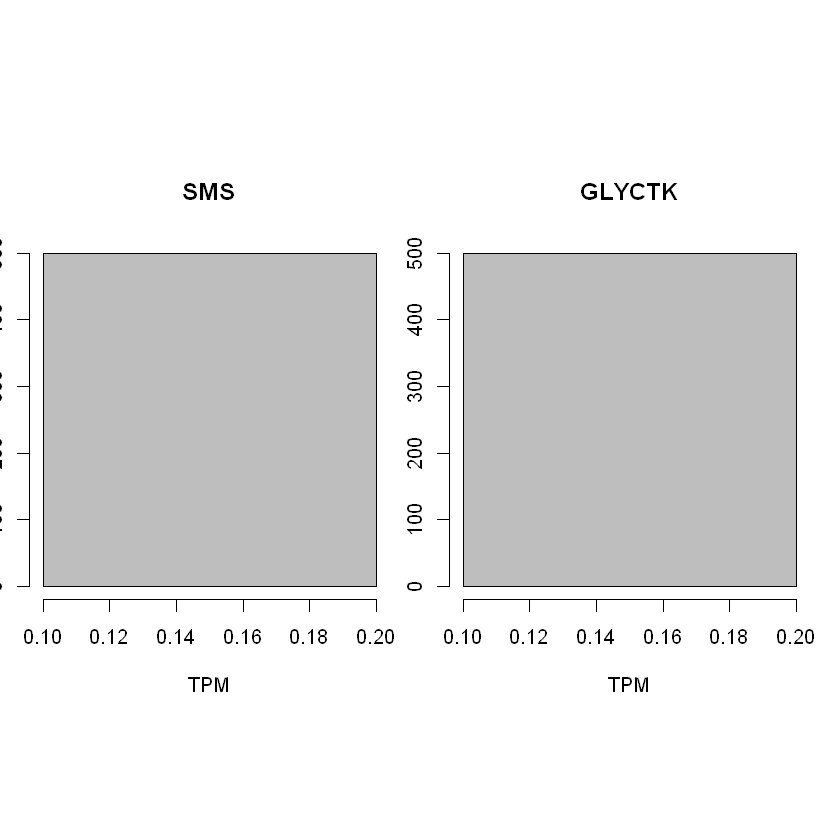

In [24]:
#pdf("gene_summary_both.pdf", height=8, width=10)

# initialize plotting space 
par(mfrow=c(1,2), pin=c(3,3))

x1 <- tpm_data[tpm_data$Gene == "ENSG00000102172", ]$TPM
h1 <- hist(x1, breaks=100, col="grey", xlab="TPM", main="SMS")
xfit1<-seq(min(na.omit(x1)),max(na.omit(x1)),length=40)
yfit1<-dnorm(xfit1,mean=mean(na.omit(x1)),sd=sd(na.omit(x1)))
yfit1 <- yfit1*diff(h1$mids[1:2])*length(na.omit(x1))
lines(xfit1, yfit1, col="blue", lwd=2)

x2 <- tpm_data[tpm_data$Gene == "ENSG00000168237", ]$TPM
h2 <- hist(x2, breaks=100, col="grey", xlab="TPM", main="GLYCTK")
xfit2<-seq(min(na.omit(x2)),max(na.omit(x2)),length=40)
yfit2<-dnorm(xfit2,mean=mean(na.omit(x2)),sd=sd(na.omit(x2)))
yfit2 <- yfit2*diff(h2$mids[1:2])*length(na.omit(x2))
lines(xfit2, yfit2, col="blue", lwd=2)

#dev.off()

### =========================================================================================

<a id="sms"><h3>SMS (ENSG00000102172)</h3></a>

#### All stages

[1] "SMS"


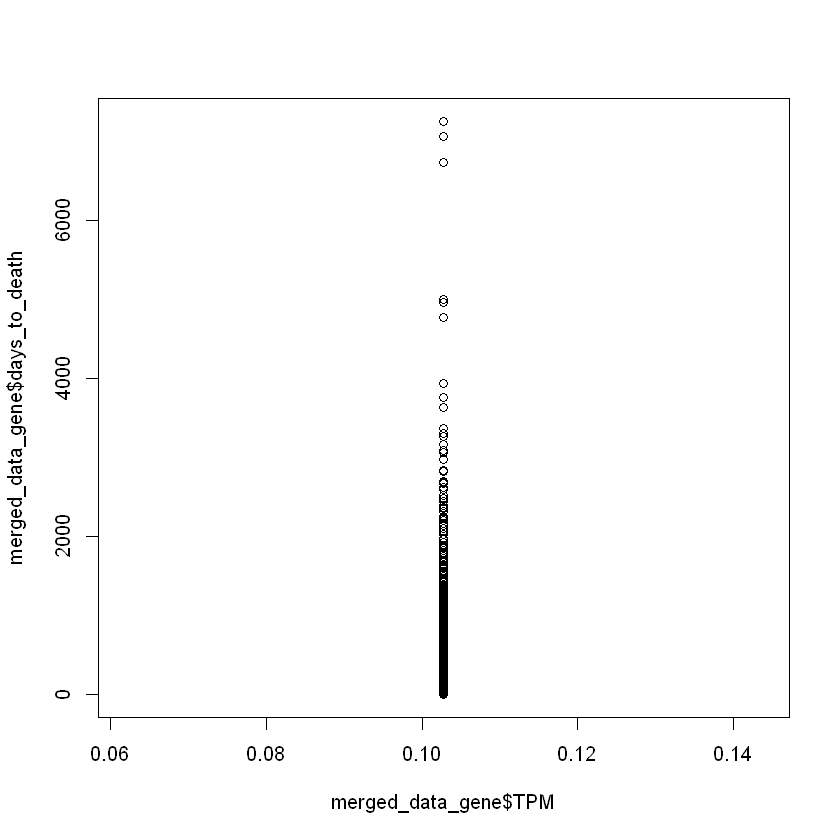

In [25]:
plot_scatter(
    tpm_data, 
    clinical_data$all, 
    "ENSG00000102172", 
    "SMS")

In [26]:
best_values_sms_all <- get_best_cutoff(
    expression=tpm_data, 
    clinical=clinical_data$all, 
    gene="ENSG00000102172", 
    title="SMS", 
    stage="All")

[1] "All ::: SMS"


ERROR: Error in cmaxstat(scores, x, weights = weights, pmethod, minprop, maxprop, : minprop too large


In [ ]:
pdf("stat_dist_sms_all.pdf")
plot(
    best_values_sms_all$cutoff_obj, 
    "TPM", 
    palette = "npg", 
    bins = 50)$TPM
dev.off()

In [ ]:
model <- best_values_sms_all$model
p_val <- best_values_sms_all$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_sms_all.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

#### Early stages

In [ ]:
plot_scatter(
    tpm_data, 
    clinical_data$early, 
    "ENSG00000102172", 
    "SMS")

In [ ]:
use_values_early <- use_cutoff(
    tpm_data, 
    clinical_data$early, 
    "ENSG00000102172", 
    best_values_sms_all$cutoff, 
    title="SMS", 
    stage="Early")

In [ ]:
model <- use_values_early$model
p_val <- use_values_early$p_val
dig_round=7
p_pos=c(6000,1)

#pdf()
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
#dev.off()

In [ ]:
best_values_sms_early <- get_best_cutoff(
    expression=tpm_data, 
    clinical=clinical_data$early, 
    gene="ENSG00000102172", 
    title="SMS", 
    stage="early")

In [ ]:
pdf("stat_dist_sms_early.pdf")
plot(
    best_values_sms_early$cutoff_obj, 
    "TPM", 
    palette = "npg", 
    bins = 50)$TPM
dev.off()

In [ ]:
model <- best_values_sms_early$model
p_val <- best_values_sms_early$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_sms_early.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

#### Late stages

In [ ]:
plot_scatter(
    tpm_data, 
    clinical_data$late, 
    "ENSG00000102172", 
    "SMS")

In [ ]:
use_values_late <- use_cutoff(
    tpm_data, 
    clinical_data$late, 
    "ENSG00000102172", 
     best_values_sms_all$cutoff, 
    title="SMS", 
    stage="Late")

In [ ]:
model <- use_values_late$model
p_val <- use_values_late$p_val
dig_round=7
p_pos=c(6000,1)

#pdf()
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
#dev.off()

In [ ]:
best_values_sms_late <- get_best_cutoff(
    expression=tpm_data, 
    clinical=clinical_data$late, 
    gene="ENSG00000102172", 
    title="SMS", 
    stage="late")

In [ ]:
pdf("stat_dist_sms_late.pdf")
plot(
    best_values_sms_late$cutoff_obj, 
    "TPM", 
    palette = "npg", 
    bins = 50)$TPM
dev.off()

In [ ]:
model <- best_values_sms_late$model
p_val <- best_values_sms_late$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_sms_late.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

### -----------------------------------------------------------------------------------------

<a id="glyctk"><h3>GLYCTK (ENSG00000168237)</h3></a>

#### All stages

In [ ]:
plot_scatter(
    tpm_data, 
    clinical_data$all, 
    "ENSG00000168237", 
    "GLYCTK")

In [ ]:
best_values_glyctk_all <- get_best_cutoff(
    tpm_data, 
    clinical_data$all, 
    "ENSG00000168237", 
    title="GLYCTK", 
    stage="All")

In [ ]:
pdf("stat_dist_glyctk_all.pdf")
plot(
    best_values_glyctk_all$cutoff_obj, 
    "TPM", 
    palette = "npg", 
    bins = 50)$TPM
dev.off()

In [ ]:
model <- best_values_glyctk_all$model
p_val <- best_values_glyctk_all$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_glyctk_all.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

#### Early stages

In [ ]:
plot_scatter(
    tpm_data, 
    clinical_data$early, 
    "ENSG00000168237", 
    "GLYCTK")

In [ ]:
use_values_early <- use_cutoff(
    tpm_data, 
    clinical_data$early, 
    "ENSG00000102172", 
    best_values_glyctk_all$cutoff, 
    title="GLYCTK", 
    stage="Early")

In [ ]:
best_values_glyctk_early <- get_best_cutoff(
    tpm_data, 
    clinical_data$early, 
    "ENSG00000168237", 
    title="GLYCTK", 
    stage="early")

In [ ]:
pdf("stat_dist_glyctk_early.pdf")
plot(
    best_values_glyctk_early$cutoff_obj, 
    "TPM", 
    palette = "npg", 
    bins = 50)$TPM
dev.off()

In [ ]:
model <- best_values_glyctk_early$model
p_val <- best_values_glyctk_early$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_glyctk_early.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

#### Late stages

In [ ]:
plot_scatter(
    tpm_data, 
    clinical_data$late, 
    "ENSG00000168237", 
    "GLYCTK")

In [ ]:
use_values_late <- use_cutoff(
    tpm_data, 
    clinical_data$late, 
    "ENSG00000102172", 
    best_values_glyctk_all$cutoff, 
    title="GLYCTK", 
    stage="Late")

In [ ]:
best_values_glyctk_late <- get_best_cutoff(
    tpm_data, 
    clinical_data$late, 
    "ENSG00000168237", 
    title="GLYCTK", 
    stage="late")

In [ ]:
pdf("stat_dist_glyctk_late.pdf")
plot(
    best_values_glyctk_late$cutoff_obj, 
    "TPM", 
    palette = "npg", 
    bins = 50)$TPM
dev.off()

In [ ]:
model <- best_values_glyctk_late$model
p_val <- best_values_glyctk_late$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_glyctk_late.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

### =========================================================================================

<a id="all"><h3>Perform analysis on all genes</h3></a> 

In [ ]:
gene_list <- unique(tpm_data$Gene)

#### All stages

In [ ]:
all_genes_all <- analyze_all_genes(
    tpm_data, 
    clinical_data$all, 
    gene_list)

#### Early stages

In [ ]:
all_genes_early <- analyze_all_genes(
    tpm_data, 
    clinical_data$early, 
    gene_list)

#### Late stages

In [ ]:
all_genes_late <- analyze_all_genes(
    tpm_data, 
    clinical_data$late, 
    gene_list)

<a id="rank"><h3>Rank order survival p-values</h3></a>

In [ ]:
# Get ranked percentile
median_pvals_sorted <- all_genes_all$median[order(unlist(all_genes_all$median), decreasing=FALSE)]
median_pvals_early_sorted <- all_genes_early$median[order(unlist(all_genes_early$median), decreasing=FALSE)]
median_pvals_late_sorted <- all_genes_late$median[order(unlist(all_genes_late$median), decreasing=FALSE)]

optimized_pvals_sorted <- all_genes_all$optimized[order(unlist(all_genes_all$optimized), decreasing=FALSE)]
optimized_pvals_early_sorted <- all_genes_early$optimized[order(unlist(all_genes_early$optimized), decreasing=FALSE)]
optimized_pvals_late_sorted <- all_genes_late$optimized[order(unlist(all_genes_late$optimized), decreasing=FALSE)]

#### SMS

In [ ]:
# Optimized

In [ ]:
print(paste((which(names(optimized_pvals_sorted) == "ENSG00000102172") / length(optimized_pvals_sorted) * 100), "%"))

In [ ]:
print((which(names(optimized_pvals_sorted) == "ENSG00000102172")))

In [ ]:
print(length(optimized_pvals_sorted))

In [ ]:
print(paste((which(names(optimized_pvals_early_sorted) == "ENSG00000102172") / length(optimized_pvals_early_sorted) * 100), "%"))

In [ ]:
print(paste((which(names(optimized_pvals_late_sorted) == "ENSG00000102172") / length(optimized_pvals_late_sorted) * 100), "%"))

In [ ]:
# Median

In [ ]:
print(paste((which(names(median_pvals_sorted) == "ENSG00000102172") / length(median_pvals_sorted) * 100), "%"))

In [ ]:
print(paste((which(names(median_pvals_early_sorted) == "ENSG00000102172") / length(median_pvals_early_sorted) * 100), "%"))

In [ ]:
print(paste((which(names(median_pvals_late_sorted) == "ENSG00000102172") / length(median_pvals_late_sorted) * 100), "%"))

#### GLYCTK

In [ ]:
# Optimized

In [ ]:
print(paste((which(names(optimized_pvals_sorted) == "ENSG00000168237") / length(optimized_pvals_sorted) * 100), "%"))

In [ ]:
print(paste((which(names(optimized_pvals_early_sorted) == "ENSG00000168237") / length(optimized_pvals_early_sorted) * 100), "%"))

In [ ]:
print(paste((which(names(optimized_pvals_late_sorted) == "ENSG00000168237") / length(optimized_pvals_late_sorted) * 100), "%"))

In [ ]:
# Median

In [ ]:
print(paste((which(names(median_pvals_sorted) == "ENSG00000168237") / length(median_pvals_sorted) * 100), "%"))

In [ ]:
print(paste((which(names(median_pvals_early_sorted) == "ENSG00000168237") / length(median_pvals_early_sorted) * 100), "%"))

In [ ]:
print(paste((which(names(median_pvals_late_sorted) == "ENSG00000168237") / length(median_pvals_late_sorted) * 100), "%"))

<a id="plots"><h3>Plots</h3></a>

In [ ]:
bump <- 1e-5

#### All stages

In [ ]:
# Optimized

In [ ]:
# Plot distribution
optimized_pvals_bh <- p.adjust(
  optimized_pvals_sorted, 
  method = "BH", 
  n = length(optimized_pvals_sorted))

pdf('bh_dist_all.pdf', width=10, height=5)
hist(
  -1 * log10(as.numeric(optimized_pvals_bh) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)
dev.off()

In [ ]:
# Median

In [ ]:
# Plot distribution
median_pvals_bh <- p.adjust(
  median_pvals_sorted, 
  method = "BH", 
  n = length(median_pvals_sorted))

#pdf('bh_dist_all.pdf')
hist(
  -1 * log10(as.numeric(median_pvals_bh) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(median_pvals_bh['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(median_pvals_bh['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)

#### Early stages

In [ ]:
# Optimized

In [ ]:
# Plot distribution
optimized_pvals_bh_early <- p.adjust(
  optimized_pvals_early_sorted, 
  method = "BH", 
  n = length(optimized_pvals_early_sorted))

pdf('bh_dist_early.pdf')
hist(
  -1 * log10(as.numeric(optimized_pvals_bh_early) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh_early['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh_early['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)
dev.off()

In [ ]:
# Median

In [ ]:
# Plot distribution
median_pvals_bh_early <- p.adjust(
  median_pvals_early_sorted, 
  method = "BH", 
  n = length(median_pvals_early_sorted))

#pdf('bh_dist_all.pdf')
hist(
  -1 * log10(as.numeric(median_pvals_bh_early) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(median_pvals_bh_early['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(median_pvals_bh_early['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)

#### Late Stages

In [ ]:
# Optimized

In [ ]:
# Plot distribution
optimized_pvals_bh_late <- p.adjust(
  optimized_pvals_late_sorted, 
  method = "BH", 
  n = length(optimized_pvals_late_sorted))

pdf('bh_dist_late.pdf')
hist(
  -1 * log10(as.numeric(optimized_pvals_bh_late) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh_late['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh_late['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)
dev.off()

In [ ]:
# Median

In [ ]:
# Plot distribution
median_pvals_bh_late <- p.adjust(
  median_pvals_late_sorted, 
  method = "BH", 
  n = length(median_pvals_late_sorted))

#pdf('bh_dist_all.pdf')
hist(
  -1 * log10(as.numeric(median_pvals_bh_late) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(median_pvals_bh_late['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(median_pvals_bh_late['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)

<a id="session"><h3>Session Info</h3></a>

In [ ]:
sessionInfo()